The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


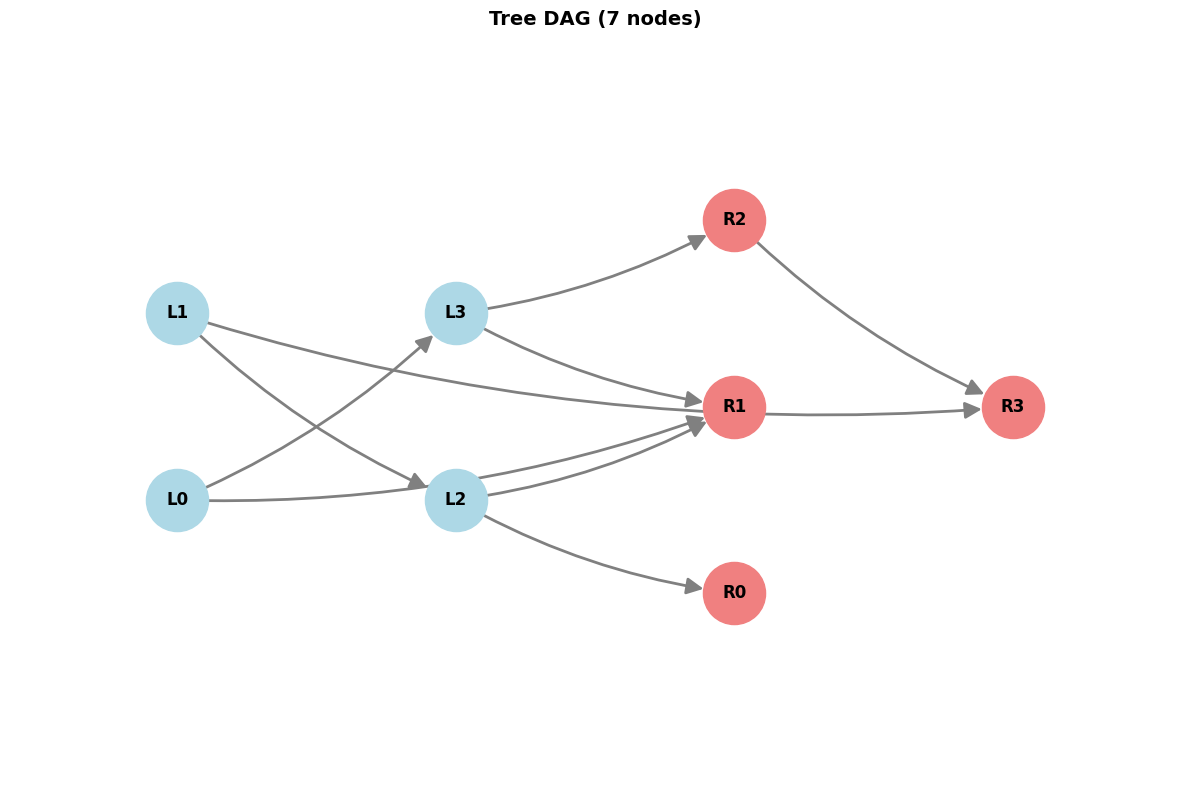

In [106]:
from symbolic_bounds.dag import DAG
%load_ext autoreload
%autoreload 2
from symbolic_bounds.test_constraints import validate_constraints


from symbolic_bounds.random_dag_generator import (
    generate_random_partitioned_dag, 
    generate_random_chain_dag,
    generate_random_tree_dag,
    print_dag_summary
)
import matplotlib.pyplot as plt



tree_dag = generate_random_partitioned_dag(n=8)
# print_dag_summary(tree_dag)
fig3 = tree_dag.draw(figsize=(12, 8), title="Tree DAG (7 nodes)")
plt.show()

# validate_constraints(tree_dag, verbose=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generated DAG with 2 nodes


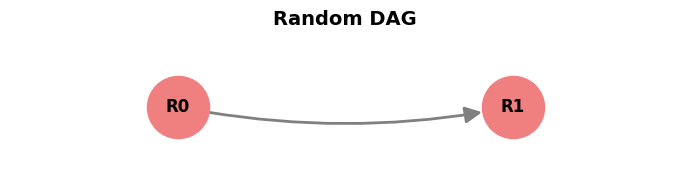


✓ DataGenerator created
symbolic bounds: [0.4909, 0.6818] for P(R0=1 | do(R1=1))
✓ SCM created

Estimated bounds for P(R0=1 | do(R1=1)): [0.490918, 0.681848]


In [11]:
# ============================================================================
# COMPLETE WORKFLOW EXAMPLE
# ============================================================================

import importlib
import sys

import numpy as np

# Force reload to avoid stale objects
if 'symbolic_bounds' in sys.modules:
    for mod in list(sys.modules.keys()):
        if mod.startswith('symbolic_bounds'):
            del sys.modules[mod]

from symbolic_bounds import DAG, DataGenerator, SCM, ProgramFactory
from symbolic_bounds.random_dag_generator import generate_random_partitioned_dag
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# 1. Generate random DAG
# dag = generate_random_partitioned_dag(n=4, binary_only=True)
dag = DAG()
R0 = dag.add_node('R0', support={0, 1})
R1 = dag.add_node('R1', support={0, 1})
# L0 = dag.add_node('L0', support={0, 1}, partition='L')
dag.add_edge(R0, R1)
# dag.add_edge(L0, R0)
dag.generate_all_response_types()
print(f"Generated DAG with {len(dag.get_all_nodes())} nodes")

# 2. Draw DAG
fig = dag.draw(figsize=(7, 2), title="Random DAG", with_labels=True)
plt.show()

# 3. Create DataGenerator
generator = DataGenerator(dag, seed=234)
print(f"\n✓ DataGenerator created")
joint = generator.computeObservedJoint() #Dict[FrozenSet[Tuple[Node, int]], float]
p11 = joint.get(frozenset({(R0, 1), (R1, 1)}))
p10 = joint.get(frozenset({(R0, 1), (R1, 0)}))
print(f'symbolic bounds: [{p11:.4f}, {1-p10:.4f}] for P(R0=1 | do(R1=1))')

# 4. Create SCM
scm = SCM(dag, generator)
print("✓ SCM created")

lp = ProgramFactory.write_LP(scm, 
                             Y={dag.get_node('R1')}, X={dag.get_node('R0')}, Y_values=(1,), X_values=(1,)
                            #  ,V={R1}, Z={R0}, V_values=(0,), Z_values=(0,)
                             )

lp.is_minimization = True
# lp.print_decision_variables()
# lp.print_objective()

lb = lp.solve(verbose=False).evaluate_objective(np.array([1]))

# UB computation is still buggy -> try for known bounds
lp.is_minimization = False
ub = -lp.solve(verbose=False).evaluate_objective(np.array([1]))
print(f"\nEstimated bounds for P(R0=1 | do(R1=1)): [{lb:.6f}, {ub:.6f}]")



In [12]:
lp = ProgramFactory.write_LP(scm, 
                             Y={dag.get_node('R1')}, X={dag.get_node('R0')}, Y_values=(1,), X_values=(1,)
                              ,V={R1}, Z={R0}, V_values=(0,), Z_values=(0,)
                             )

lp.is_minimization = True
# lp.print_decision_variables()
# lp.print_objective()

lb = lp.solve(verbose=False).evaluate_objective(np.array([1]))

# UB computation is still buggy -> try for known bounds
lp.is_minimization = False
ub = lp.solve(verbose=False).evaluate_objective(np.array([1]))
# print(f"\nEstimated bounds for P(R0=1 | do(R1=1)): [{lb:.6f}, {ub:.6f}]")

true_prob = generator.computeTrueIntervention(
    Y={R1}, 
    X={R0}, 
    Y_values=(1,), 
    X_values=(1,)
)
print(f"True P(Y=1 | do(X=1)) = {true_prob:.6f}")
lp.solve(verbose=True).evaluate_objective(np.array([true_prob]))


True P(Y=1 | do(X=1)) = 0.606769
Building MPLP_Program:
  Variables: 8

Processing constraints (removing redundancies)...


-0.6818481436106607

In [ ]:
# ============================================================================
# COMPLETE WORKFLOW EXAMPLE
# ============================================================================

import importlib
import sys

# Force reload to avoid stale objects
if 'symbolic_bounds' in sys.modules:
    for mod in list(sys.modules.keys()):
        if mod.startswith('symbolic_bounds'):
            del sys.modules[mod]

from symbolic_bounds import DAG, DataGenerator, SCM, ProgramFactory
from symbolic_bounds.random_dag_generator import generate_random_partitioned_dag
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

# 1. Generate DAG

dag = DAG()
X = dag.add_node("X", {0, 1}, 'R')
Y = dag.add_node("Y", {0, 1}, 'R')
Z = dag.add_node("Z", {0, 1}, 'L')

dag.add_edge(Z, X)
dag.add_edge(X, Y)

dag.generate_all_response_types()
print(f"Generated DAG with {len(dag.get_all_nodes())} nodes")

# # 2. Draw DAG
# fig = dag.draw(figsize=(10, 6), title="Random DAG")
# plt.show()

# 3. Create DataGenerator
generator = DataGenerator(dag, seed=123)
print(f"\n✓ DataGenerator created")
# Get true causal effect
true_prob = generator.computeTrueIntervention(
    Y={Y}, 
    X={X}, 
    Y_values=(1,), 
    X_values=(1,)
)
print(f"True P(Y=1 | do(X=1)) = {true_prob:.6f}")
# 4. Create SCM
scm = SCM(dag, generator)
print("✓ SCM created")

lp = ProgramFactory.write_LP(scm, Y={dag.get_node('Y')}, X={dag.get_node('X')}, Y_values=(1,), X_values=(1,))

lp.solve(verbose=False).evaluate_objective(np.array([1]))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generated DAG with 3 nodes

✓ DataGenerator created
True P(Y=1 | do(X=1)) = 0.439906
✓ SCM created


0.18432298479456904